In [1]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [2]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 50
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "C:\\Users\\MIHIR\\Desktop\\proj2\\potato\\PlantVillage"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
# total 2152 images are there, classified into 3 categories ('Potato___Early_blight', 'Potato___Late_blight','Potato___healthy)
# pipeline is created to send data in batches
# 32 batcges are created(BATCH_SIZE)
# each batch has size of 68.

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)



Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


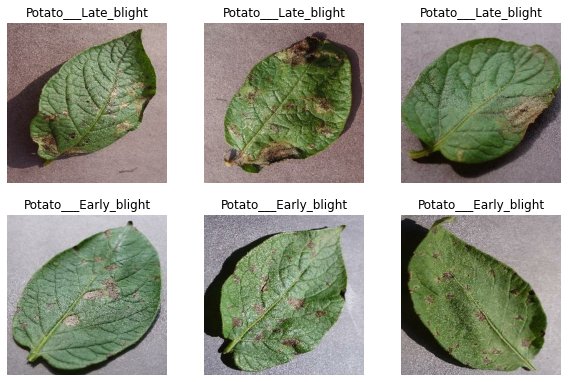

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
len(dataset)

68

# Initializing, Exploring & Partioning the Dataset
## Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training                                                             
Validation: Dataset to be tested against while training                               
Test: Dataset to be tested against after we trained a model

In [8]:
# traing size is 80%
# test size is 20% (validation is 10 and test is 10)

In [9]:
#train_size = 0.8
#len(dataset)*train_size
#train_ds = dataset.take(54) #slicing
#len(train_ds)

In [10]:
#test_ds = dataset.skip(54) #slicing
#len(test_ds)

In [11]:
#val_size = 0.1
#len(dataset)*val_size

In [12]:
#val_ds = test_ds.take(6)
#len(val_ds)

In [13]:
#test_ds = test_ds.skip(6)
#len(test_ds)

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
print(len(train_ds),len(val_ds),len(test_ds))

54 6 8


## Cache, Shuffle, and Prefetch the Dataset


In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# PREPROCESSING

## Creating a Layer for Resizing and Normalization

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

###  Checking what is the expected dimension order for channel


In [20]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

## Model Architecture

##### We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.


In [21]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=batch_input_shape)


In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

## Compiling the Model 

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## Training the Network


In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
54/54 [==============================] - 59s 1s/step - loss: 0.9172 - accuracy: 0.4977 - val_loss: 0.8547 - val_accuracy: 0.5104
Epoch 2/50
54/54 [==============================] - 53s 973ms/step - loss: 0.6692 - accuracy: 0.7112 - val_loss: 0.5196 - val_accuracy: 0.8021
Epoch 3/50
54/54 [==============================] - 53s 980ms/step - loss: 0.3891 - accuracy: 0.8391 - val_loss: 0.2891 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 61s 1s/step - loss: 0.2800 - accuracy: 0.8958 - val_loss: 0.2164 - val_accuracy: 0.9010
Epoch 5/50
54/54 [==============================] - 61s 1s/step - loss: 0.2627 - accuracy: 0.8924 - val_loss: 0.2559 - val_accuracy: 0.8958
Epoch 6/50
54/54 [==============================] - 61s 1s/step - loss: 0.2707 - accuracy: 0.8935 - val_loss: 0.1609 - val_accuracy: 0.9271
Epoch 7/50
54/54 [==============================] - 59s 1s/step - loss: 0.2136 - accuracy: 0.9207 - val_loss: 0.3115 - val_accuracy: 0.8646
Epoch 8/50
54/

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [1]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f" Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

NameError: name 'plt' is not defined

In [27]:
import os
model_version=max([int(i) for i in os.listdir("C:\Users\MIHIR\Desktop\potato\models") + [0]])+1
model.save(f"../models/{model_version}")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (3722784921.py, line 2)